1. Load the MNIST dataset (introduced in chapter 3)

- Split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

- Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the accuracy score of the resulting model on the test set.  Attempt to scale the X since PCA will benefit from that.

- Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

- Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Why?  Next evaluate the classifier on the test set: how does it compare to the previous classifier?

- Repeat the above steps using LogisticRegression with multi-class="multinomial" and solver="lbfgs" .  Was training much faster with PCA?  Do accuracy lower after PCA? (ignore the convergence warning since you can easily set max_iter to higher to remove this warning; here we care for time)

In [1]:
# Your code here

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

2. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class. Then try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations

- When you compare the visualizations, you do not really have any metric, but one way to tell is whether this visualization separate each class well enough for eyes to see.

- Since t-SNE is even more time-consuming, try to obtain only 5000 images.  And since t-SNE is more about visualization, it does not require you to train-test split here.

- For MDS, be warned it will take long long time.  Try to reduce to perhaps 1000 images for your good mental state.

- Once you compare all singular models.  For last model, try a pipeline of 

<code>pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])</code>

So what do you think the above pipeline does? How is the time compared to tsne only?

3. Attempt to compare the followings:

 1. SVM prediction with PCA of 0.99 explained variances
 2. SVM prediction with PCA of 0.90 explained variances

- you probably want to use grid search to find the best C and gamma
- since image is non-linear, it may be wise to use rbf/poly kernel
- since there are imbalanced set of target images, use class_weight='balanced'
- for pca, since we are working with images, with many correlated pixels
- it is useful to use whiten=True which will transform our covariance matrix to unit matrix (it is similar to standardizing your PCA)

How much time differences between the two?

How about the accuracy? (Hint: accuracy should be avoided in imbalanced dataset)

Is the result expected?

In [1]:
from sklearn.datasets import fetch_lfw_people

# Your code here

from time import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lfw_people = fetch_lfw_people(min_faces_per_person=70)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7


4. Convert the above PCA using kernel PCA, where we convert our X using rbf kernels.  You may want to see how to transfer your data to another space via https://en.wikipedia.org/wiki/Radial_basis_function_kernel and this http://rasbt.github.io/mlxtend/user_guide/feature_extraction/RBFKernelPCA/#References. For those who are confused what is x and x' (prime), they are basically each sample, so you may want to first find the squared distances between each sample.  Apply your kernel PCA with a sklearn datasets make_swiss_roll

#### More details on Kernel PCA

The steps are as follows:

1). Calculate (x-x')^2

For your convenience, to get the squared distances can be done using the pdist module. Then transform it into a square form using squareform module.

<code>from scipy.spatial.distance import pdist </code>

<code>distances = pdist(X, 'sqeuclidean')</code>

<code>matrix = squareform(squared_distances)</code>

BTW, if you prefer the numpy way, it is also perfectly fine!

2). Center the data

This is a bit tricky but http://rasbt.github.io/mlxtend/user_guide/feature_extraction/RBFKernelPCA/#References has provided us how to center the rbf data.

3). Calculate rbf = exp(-gamma * matrix)

As for gamma, you can actually pick whatever gamma you prefer. Then you would want to calculate the rbf kernel

<code>rbf = np.exp(-gamma * matrix)</code>

once you obtain the rbf, you DO NOT need to input into the np.cov, because by performing squared_distances we are actually doing covariances but in rbf space. 

(Notice we are not doing x - x' in normal covariance way, but (x - x')^2)

4).  Use eig to calculate the eigenvectors and values

5). Get the projection and plot it. 

When you project your data, you do rbf @ eigenvectors, NOT X @ eigenvectors since your eigenvectors are in rbf space

yes, that's it!

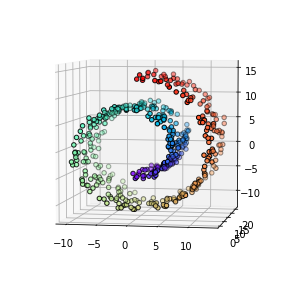

In [20]:
#use the following data
from sklearn import manifold, datasets

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

#elevation and #azimuth
ax.view_init(5, -80)

X, color = datasets.make_swiss_roll(n_samples=500, noise=0.3)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap="rainbow",
          edgecolor='k')

5. Implement ISOmap from scratch. Reduced to 200 samples for peace of mind.
<code>X, color = datasets.make_swiss_roll(n_samples=200, noise=0.3)</code>

- Since ISOmap is essential very similar to MDS but instead of a simple distance matrix, it feeds in a shortest path matrix instead, hence the geodesic distances.

- First, compute the distances.  Make sure it is euclidean for this step. Also make sure that the distance matrix should have values for only the nth nearest neighbors. Otherwise, values should be infinity. Infinity will be later on used by Floyd algorithm to determine the shortest paths. Last, treat this distance matrix as undirected graph, which means <code>distance\[i\]\[j\]</code> should be same as <code>distance\[j\]\[i\]</code>

- Second, input the distance matrix into Floyd algorithm. This part can be unfamiliar for those who did not study Data Structures and Algorithms.  

- Floyd Warshall algorithm is basically a all-pairs shortest-path algorithm. It is pretty straightforward algorithm in which you loop through all possible pair of vertices and their possible paths and keep on updating if shorter path is found. Code is provided below.

- This is implemented based on pseudocode given in https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm.

- For those who want to first get an intuition, watch this https://www.youtube.com/watch?v=4OQeCuLYj-4.

In [23]:
def floydWarshall(distance_matrix):
    #shorten the name for shorter code!
    #I write the long name as param so you guys will know
    #what is it that is being input to floyd
    dist = distance_matrix
    length = len(dist)
    for k in range(length):
        for i in range(length):
            for j in range(length):
                dist[i][j] = min(dist[i][j],dist[i][k] + dist[k][j])
    return graph_matrix

Third, you need to feed the graph matrix to the MDS algorithm. This MDS algorithm is quite straightforward as well.
For simplicity, you can follow the steps written in https://en.wikipedia.org/wiki/Multidimensional_scaling in topic "Steps of a classical MDS algorithm"

1. Squared the incoming matrix return my floyd

2. Perform double centering which center the data, and remove asymmetrical distances by multiplying 0.5

3. Use elg() to find eigenvalues and eigenvectors

4. The new X = Em(Am)^1/2, where EM is eigenvectors and Am is the diagonal matrix of eigenvalues

Phew, it may look hard, but it is always satisfying to understand the math behind!

In [24]:
#Implement ISOmap from scratch
#reduced to 200 samples for peace of mind
X, color = datasets.make_swiss_roll(n_samples=200, noise=0.3)

# Your code here